## Google's Word2Vec for movie reviews

https://www.kaggle.com/c/word2vec-nlp-tutorial  
https://github.com/wendykan/DeepLearningMovies  
http://fastml.com/classifying-text-with-bag-of-words-a-tutorial/  


In this tutorial competition, we dig a little "deeper" into sentiment analysis. Google's Word2Vec is a deep-learning inspired method that focuses on the meaning of words. Word2Vec attempts to understand meaning and semantic relationships among words. It works in a way that is similar to deep approaches, such as recurrent neural nets or deep neural nets, but is computationally more efficient. This tutorial focuses on Word2Vec for sentiment analysis.

Sentiment analysis is a challenging subject in machine learning. People express their emotions in language that is often obscured by sarcasm, ambiguity, and plays on words, all of which could be very misleading for both humans and computers. There's another Kaggle competition for movie review sentiment analysis. In this tutorial we explore how Word2Vec can be applied to a similar problem.

Deep learning has been in the news a lot over the past few years, even making it to the front page of the New York Times. These machine learning techniques, inspired by the architecture of the human brain and made possible by recent advances in computing power, have been making waves via breakthrough results in image recognition, speech processing, and natural language tasks. Recently, deep learning approaches won several Kaggle competitions, including a drug discovery task, and cat and dog image recognition.

#### Let's charge the batteries for our analysis...

In [1]:
import os
import sys
import time
import re
import pickle
import logging

from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import pylab
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
#import seaborn as sns
#import seaborn.apionly as sns

import nltk
import nltk.data
from nltk.corpus import stopwords

from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score as AUC

import gensim
from gensim.models import Word2Vec

%matplotlib inline
#%pylab inline

Data Set  
--

The labeled data set consists of 50,000 IMDB movie reviews, specially selected for sentiment analysis. The sentiment of reviews is binary, meaning the IMDB rating < 5 results in a sentiment score of 0, and rating >=7 have a sentiment score of 1. No individual movie has more than 30 reviews. The 25,000 review labeled training set does not include any of the same movies as the 25,000 review test set. In addition, there are another 50,000 IMDB reviews provided without any rating labels.

File descriptions

labeledTrainData - The labeled training set. The file is tab-delimited and has a header row followed by 25,000 rows containing an id, sentiment, and text for each review.  

testData - The test set. The tab-delimited file has a header row followed by 25,000 rows containing an id and text for each review. Your task is to predict the sentiment for each one. 

unlabeledTrainData - An extra training set with no labels. The tab-delimited file has a header row followed by 50,000 rows containing an id and text for each review. 

sampleSubmission - A comma-delimited sample submission file in the correct format.
Data fields

id - Unique ID of each review
sentiment - Sentiment of the review; 1 for positive reviews and 0 for negative reviews
review - Text of the review

Loading the dataset:  
--

In [2]:
datapath = "../datasets/Kaggle/"
outputs = "../outputs/"

In [3]:
train = pd.read_csv(os.path.join(datapath, 'BOW_labeledTrainData.tsv'), header=0, delimiter="\t", quoting=3)
test = pd.read_csv(os.path.join(datapath, 'BOW_testData.tsv'), header=0, delimiter="\t", quoting=3)
unlabeled_train = pd.read_csv(os.path.join(datapath, "BOW_unlabeledTrainData.tsv"), header=0, delimiter="\t", quoting=3)

In [4]:
print("Read {} labeled train reviews, \
{} labeled test reviews, and \
{} unlabeled reviews\n".format(train["review"].size,
                               test["review"].size,
                               unlabeled_train["review"].size))

Read 25000 labeled train reviews, 25000 labeled test reviews, and 50000 unlabeled reviews



In [5]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
id           25000 non-null object
sentiment    25000 non-null int64
review       25000 non-null object
dtypes: int64(1), object(2)
memory usage: 586.0+ KB


In [7]:
train.describe()

,sentiment
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


Part 1: For Beginners - Bag of Words
--
https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words  

What is NLP?

NLP (Natural Language Processing) is a set of techniques for approaching text problems. This page will help you get started with loading and cleaning the IMDB movie reviews, then applying a simple Bag of Words model to get surprisingly accurate predictions of whether a review is thumbs-up or thumbs-down.

In [8]:
class KaggleWord2VecUtility(object):
    """KaggleWord2VecUtility is a utility class for processing raw HTML text into segments for further learning"""

    @staticmethod
    def review_to_wordlist(review, remove_stopwords=False):
        # Function to convert a document to a sequence of words, optionally removing stop words.  
        # Returns a list of words.
        # 1. Remove HTML
        review_text = BeautifulSoup(review, "lxml").get_text()
        # 2. Remove non-letters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
        # 3. Convert words to lower case and split them
        words = review_text.lower().split()
        # 4. Optionally remove stop words (false by default)
        if remove_stopwords:
            stops = set(stopwords.words("english"))
            words = [w for w in words if not w in stops]
        # 5. Return a list of words
        return(words)

    @staticmethod
    def review_to_sentences(review, tokenizer, remove_stopwords=False):
        # Function to split a review into parsed sentences. Returns a
        # list of sentences, where each sentence is a list of words
        #
        # 1. Use the NLTK tokenizer to split the paragraph into sentences
        #raw_sentences = tokenizer.tokenize(review.decode('utf8').strip())
        raw_sentences = tokenizer.tokenize(review.strip())
        #
        # 2. Loop over each sentence
        sentences = []
        for raw_sentence in raw_sentences:
            # If a sentence is empty, skip it
            if len(raw_sentence) > 0:
                # Otherwise, call review_to_wordlist to get a list of words
                sentences.append(KaggleWord2VecUtility.review_to_wordlist(raw_sentence, remove_stopwords))
        # Return the list of sentences (each sentence is a list of words,
        # so this returns a list of lists
        return sentences

Cleaning all the datasets and getting word lists
--
first set is without stopwords

In [10]:
clean_train_reviews = []
for i in range(0, len(train["review"])):
    clean_train_reviews.append(" ".join(KaggleWord2VecUtility.review_to_wordlist(train["review"][i], True)))
clean_train_reviews[99:101]

['may critic think movie well watched movie cinemax first say much hate storyline mean come snowman scare besides little kids secondly pretty gory bet since movie low budget probably used ketchup critical vote bomb nice try sequel suck twice much',
 'uk edition show rather less extravagant us version person concerned get new kitchen perhaps bedroom bathroom wonderfully grateful got us version show everything reality tv instead making improvements house occupants could afford entire house gets rebuilt know show trying show lousy welfare system exists us beg hard enough receive rather vulgar product placement takes place particularly sears also uncalled rsther turning one family deprived area potential millionaires would far better help community whole instead spending hundreds thousands dollars one home build something whole community perhaps place diy power tools borrowed returned along building materials everyone benefit want giving one person cause enormous resentment among rest loca

In [11]:
clean_test_reviews = []
for i in range(0,len(test["review"])):
    clean_test_reviews.append(" ".join(KaggleWord2VecUtility.review_to_wordlist(test["review"][i], True)))
clean_test_reviews[99:101]

['young theater actress reluctantly accepts first major part staged play lady macbeth thanks mishap production diva falling front moving car success winning accolades betty christina marsillach finds instead horror one responsible getting point terrorizes cruel ways first stage manager boyfriend stefano william mcnamara viciously stabbed knife watch rope tied pillar uncle vast mansion keeping eyes closing thanks needles scotch taped eyes pricking result blinks allowing escape betty finds unfortunate position specific gold chain found lady macbeth wardrobe torn shreds madman killing series crows escaped cage equipment room clothing designer first knocked floor iron subsequently stabbed heinously pair scissors cap nasty scene chain falls throat killer cut open throat find specifically elaborating act dario uses ripping sound scissors optimum effect camera often retreating back victim dead face nowhere turn inspector alan santini urbano barberini playing cold bland dario request promises 

Saving Pickles 

In [12]:
with open(os.path.join(outputs, 'clean_reviews.pkl'),'wb') as f:
    pickle.dump((clean_train_reviews, clean_test_reviews),f)

Loading Pickle

In [13]:
with open(os.path.join(outputs, 'clean_reviews.pkl'),'rb') as f:
    clean_train_reviews, clean_test_reviews = pickle.load(f)

Second set mantains stopwords

In [14]:
clean_train_reviews_sw = []
for i in range(0, len(train["review"])):
    clean_train_reviews_sw.append(" ".join(KaggleWord2VecUtility.review_to_wordlist(train["review"][i], False)))
    
clean_train_reviews_sw[99:101]

['i may not be a critic but here is what i think of this movie well just watched the movie on cinemax and first of all i just have to say how much i hate the storyline i mean come on what does a snowman scare besides little kids secondly it is pretty gory but i bet since the movie is so low budget they probably used ketchup so my critical vote is bomb nice try and the sequel will suck twice as much',
 'there is a uk edition to this show which is rather less extravagant than the us version the person concerned will get a new kitchen or perhaps bedroom and bathroom and is wonderfully grateful for what they have got the us version of this show is everything that reality tv shouldn t be instead of making a few improvements to a house which the occupants could not afford or do themselves the entire house gets rebuilt i do not know if this show is trying to show what a lousy welfare system exists in the us or if you beg hard enough you will receive the rather vulgar product placement that ta

In [15]:
clean_test_reviews_sw = []
for i in range(0,len(test["review"])):
    clean_test_reviews_sw.append(" ".join(KaggleWord2VecUtility.review_to_wordlist(test["review"][i], False)))
    
clean_test_reviews_sw[99:101]

['a young theater actress reluctantly accepts her first major part in a staged play as lady macbeth thanks to the mishap of the production s diva falling in front of a moving car a success winning her accolades betty christina marsillach finds instead horror as the one responsible for getting her to this point terrorizes her in cruel ways first her stage manager boyfriend stefano william mcnamara is viciously stabbed with a knife while she has to watch rope tied to a pillar in his uncle s vast mansion keeping her eyes from closing thanks to needles scotch taped under her eyes with pricking a result if she blinks allowing her to escape betty again finds herself in this unfortunate position when a specific gold chain is found on her lady macbeth wardrobe that had been torn to shreds by the madman after killing a series of crows which escaped from their cage in the equipment room by the clothing designer who is first knocked to the floor by an iron and subsequently stabbed heinously by a 

Saving Pickle

In [16]:
with open(os.path.join(outputs, 'clean_reviews_sw.pkl'),'wb') as f:
    pickle.dump((clean_train_reviews_sw, 
                 clean_test_reviews_sw),f)

Loading Pickle  

In [17]:
with open(os.path.join(outputs, 'clean_reviews_sw.pkl'),'rb') as f:
    clean_train_reviews_sw, clean_test_reviews_sw = pickle.load(f)

Creating Features from a Bag of Words (Using scikit-learn)
--

Now that we have our training reviews tidied up, how do we convert them to some kind of numeric representation for machine learning? One common approach is called a Bag of Words. The Bag of Words model learns a vocabulary from all of the documents, then models each document by counting the number of times each word appears. For example, consider the following two sentences:

Sentence 1: "The cat sat on the hat"  
Sentence 2: "The dog ate the cat and the hat"  

From these two sentences, our vocabulary is as follows:

{ the, cat, sat, on, hat, dog, ate, and }

To get our bags of words, we count the number of times each word occurs in each sentence. In Sentence 1, "the" appears twice, and "cat", "sat", "on", and "hat" each appear once, so the feature vector for Sentence 1 is:

{ the, cat, sat, on, hat, dog, ate, and }

Sentence 1: { 2, 1, 1, 1, 1, 0, 0, 0 }

Similarly, the features for Sentence 2 are: { 3, 1, 0, 0, 1, 1, 1, 1}

In the IMDB data, we have a very large number of reviews, which will give us a large vocabulary. To limit the size of the feature vectors, we should choose some maximum vocabulary size. Below, we use the 5000 most frequent words (remembering that stop words have already been removed).

We'll be using the feature_extraction module from scikit-learn to create bag-of-words features.  

We will test two strategies: CountVectorizer and Tfidf Vectorizer:  
First we'll start with plain word counts:  

In [18]:
# Initialize the "CountVectorizer" object, which is scikit-learn's bag of words tool.
#http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
vectorizer1 = CountVectorizer(input='content', 
                              encoding='utf-8', 
                              decode_error='strict', 
                              strip_accents=None, 
                              lowercase=True, 
                              preprocessor=None, 
                              tokenizer=None, 
                              stop_words=None, 
                              #token_pattern='(?u)\b\w\w+\b',
                              ngram_range=(1, 1),
                              analyzer='word', 
                              max_df=1.0, 
                              min_df=1, 
                              max_features=5000, 
                              vocabulary=None, 
                              binary=False, 
                              dtype=np.int64,
                             )

Fit_transform() does two functions: First, it fits the model and learns the vocabulary; 
second, it transforms our training data into feature vectors. 
The input to fit_transform should be a list of strings.

In [19]:
train_data_features1 = vectorizer1.fit_transform(clean_train_reviews)
train_data_features1 = train_data_features1.toarray() # Numpy arrays are easy to work with
print(train_data_features1.shape)

(25000, 5000)


In [20]:
test_data_features1 = vectorizer1.fit_transform(clean_test_reviews)
test_data_features1 = test_data_features1.toarray() # Numpy arrays are easy to work with
print(test_data_features1.shape)

(25000, 5000)


Saving Pickle

In [21]:
with open(os.path.join(outputs, 'train_data_features1.pkl'),'wb') as f:
    pickle.dump(train_data_features1,f)

In [22]:
with open(os.path.join(outputs, 'test_data_features1.pkl'),'wb') as f:
    pickle.dump(test_data_features1,f)

Reading Pickle

In [23]:
with open(os.path.join(outputs, 'train_data_features1.pkl'),'rb') as f:
    train_data_features1 = pickle.load(f)

In [24]:
with open(os.path.join(outputs, 'test_data_features1.pkl'),'rb') as f:
    test_data_features1 = pickle.load(f)

Now we are going to use TfIDf vectors:

In [25]:
#http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
#Another approach using TfIDf vectorizer and using the texts with stopwords in:
#https://github.com/zygmuntz/classifying-text/blob/master/bow_predict.py 
vectorizer2 = TfidfVectorizer(input='content',
                              #encoding='utf-8',
                              decode_error='strict',
                              strip_accents=None,
                              lowercase=True,
                              preprocessor=None,
                              tokenizer=None,
                              analyzer='word',
                              stop_words=None,
                              #token_pattern='(?u)\b\w\w+\b',
                              ngram_range=(1, 3),
                              max_df=1.0,
                              min_df=1,
                              max_features=6000,
                              vocabulary=None, 
                              binary=False, 
                              dtype=np.int64,
                              norm='l2',
                              use_idf=True,
                              smooth_idf=True,
                              sublinear_tf=True)

In [26]:
train_data_features2 = vectorizer2.fit_transform(clean_train_reviews_sw)
train_data_features2 = train_data_features2.toarray() # Numpy arrays are easy to work with
print(train_data_features2.shape)

(25000, 6000)


In [27]:
test_data_features2 = vectorizer2.fit_transform(clean_test_reviews_sw)
test_data_features2 = test_data_features2.toarray() # Numpy arrays are easy to work with
print(test_data_features2.shape)

(25000, 6000)


Saving Pickle  

In [28]:
with open(os.path.join(outputs, 'train_data_features2.pkl'),'wb') as f:
    pickle.dump(train_data_features2,f)

In [29]:
with open(os.path.join(outputs, 'test_data_features2.pkl'),'wb') as f:
    pickle.dump(test_data_features2,f)

Reading Pickle  

In [30]:
with open(os.path.join(outputs, 'train_data_features2.pkl'),'rb') as f:
    train_data_features2 = pickle.load(f)

In [31]:
with open(os.path.join(outputs, 'test_data_features2.pkl'),'rb') as f:
    test_data_features2 = pickle.load(f)

Dividing Train set for Cross Validation  
--

https://github.com/zygmuntz/classifying-text/blob/master/bow_validate.py  
Alternatively, we can use the indexes to divide the train samples  

train_i, test_i = train_test_split(np.arange(len(train)), train_size = 0.8, random_state = 44)  

After generating indexes, we can divide ou datasets:  
traincv = train_data_features1[train_i]  
testcv = train_data_features1[test_i]

In [32]:
#Plain Word Counts
X_traincv1, X_testcv1, y_traincv1, y_testcv1 = train_test_split(train_data_features1,
                                                                train["sentiment"],
                                                                test_size=0.2,
                                                                random_state=0)

In [33]:
#TfIdf
X_traincv2, X_testcv2, y_traincv2, y_testcv2 = train_test_split(train_data_features2,
                                                                train["sentiment"],
                                                                test_size=0.2,
                                                                random_state=0)

Let's create a helper function to evaluate the classifiers:  

In [34]:
def mean_scores_cv(clf, cv, X, y):
    scores = cross_validation.cross_val_score(clf, X, y, 
                                              scoring=None, 
                                              cv=cv, 
                                              n_jobs=-1,
                                              verbose=0,
                                              fit_params=None,
                                              pre_dispatch='2*n_jobs')
    return scores.mean()

Training some Classifiers  
--

Random Forest
--

At this point, we have numeric training features from the Bag of Words and the original sentiment labels for each feature vector, so let's do some supervised learning! Here, we'll use the Random Forest classifier.  The Random Forest algorithm is included in scikit-learn (Random Forest uses many tree-based classifiers to make predictions, hence the "forest"). Below, we set the number of trees to 100 as a reasonable default value. More trees may (or may not) perform better, but will certainly take longer to run. Likewise, the more features you include for each review, the longer this will take.

In [35]:
# Initialize a Random Forest classifier with 300 trees
from sklearn.ensemble import RandomForestClassifier

clf_RF_1 = RandomForestClassifier(n_estimators=300, 
                                  criterion='gini', 
                                  max_depth=None, 
                                  min_samples_split=2, 
                                  min_samples_leaf=1, 
                                  min_weight_fraction_leaf=0.0, 
                                  max_features='auto', 
                                  max_leaf_nodes=None, 
                                  bootstrap=False, 
                                  oob_score=False, 
                                  n_jobs=-1, 
                                  random_state=0, 
                                  verbose=0, 
                                  warm_start=False, 
                                  class_weight=None).fit(X_traincv1, y_traincv1)

eval_RF_1_tts = clf_RF_1.score(X_testcv1, y_testcv1)
print(eval_RF_1_tts)

0.8586


In [36]:
clf_RF_1.predict_proba(X_testcv1)

array([[ 0.44666667,  0.55333333],
       [ 0.38666667,  0.61333333],
       [ 0.35666667,  0.64333333],
       ..., 
       [ 0.37666667,  0.62333333],
       [ 0.80666667,  0.19333333],
       [ 0.17666667,  0.82333333]])

Now we are going to train on the TfIdf samples:

In [37]:
# Initialize a Random Forest classifier with 300 trees
clf_RF_2 = RandomForestClassifier(n_estimators=300, 
                                  criterion='gini', 
                                  max_depth=None, 
                                  min_samples_split=2, 
                                  min_samples_leaf=1, 
                                  min_weight_fraction_leaf=0.0, 
                                  max_features='auto', 
                                  max_leaf_nodes=None, 
                                  bootstrap=False, 
                                  oob_score=False, 
                                  n_jobs=-1, 
                                  random_state=0, 
                                  verbose=0, 
                                  warm_start=False, 
                                  class_weight=None).fit(X_traincv2, y_traincv2)

eval_RF_2_tts = clf_RF_2.score(X_testcv2, y_testcv2)
print(eval_RF_2_tts)

0.8532


In [38]:
clf_RF_2.predict_proba(X_testcv2)

array([[ 0.46666667,  0.53333333],
       [ 0.29666667,  0.70333333],
       [ 0.22333333,  0.77666667],
       ..., 
       [ 0.25333333,  0.74666667],
       [ 0.75666667,  0.24333333],
       [ 0.28333333,  0.71666667]])

Logistic Regression  
--

In [39]:
#http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
from sklearn.linear_model import LogisticRegression as LR

clf_LR_1 = LR(penalty='l2',
              dual=False,
              tol=0.0001,
              C=1.0,
              fit_intercept=True,
              intercept_scaling=1,
              class_weight=None,
              random_state=None,
              solver='liblinear',
              max_iter=100,
              multi_class='ovr',
              verbose=0).fit(X_traincv1, y_traincv1)

eval_LR_1_tts = clf_LR_1.score(X_testcv1, y_testcv1)
print(eval_LR_1_tts)

0.8586


In [40]:
clf_LR_2 = LR(penalty='l2',
              dual=False,
              tol=0.0001,
              C=1.0,
              fit_intercept=True,
              intercept_scaling=1,
              class_weight=None,
              random_state=None,
              solver='liblinear',
              max_iter=100,
              multi_class='ovr',
              verbose=0).fit(X_traincv2, y_traincv2)

eval_LR_2_tts = clf_LR_2.score(X_testcv2, y_testcv2)
print(eval_LR_2_tts)

0.8926


Gradient Boost Classifier  
--

In [41]:
#http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
from sklearn.ensemble import GradientBoostingClassifier

clf_GBC_1 = GradientBoostingClassifier(loss='deviance',
                                       learning_rate=0.1,
                                       n_estimators=100,
                                       subsample=1.0,
                                       min_samples_split=2,
                                       min_samples_leaf=1,
                                       min_weight_fraction_leaf=0.0,
                                       max_depth=3,
                                       init=None,
                                       random_state=0,
                                       max_features=None,
                                       verbose=0,
                                       max_leaf_nodes=None,
                                       warm_start=False,
                                       presort='auto').fit(X_traincv1, y_traincv1)

eval_GBC_1_tts = clf_GBC_1.score(X_testcv1, y_testcv1)
print(eval_GBC_1_tts)

0.8066


In [42]:
clf_GBC_2 = GradientBoostingClassifier(loss='deviance',
                                       learning_rate=0.1,
                                       n_estimators=100,
                                       subsample=1.0,
                                       min_samples_split=2,
                                       min_samples_leaf=1,
                                       min_weight_fraction_leaf=0.0,
                                       max_depth=3,
                                       init=None,
                                       random_state=0,
                                       max_features=None,
                                       verbose=0,
                                       max_leaf_nodes=None,
                                       warm_start=False,
                                       presort='auto').fit(X_traincv2, y_traincv2)

eval_GBC_2_tts = clf_GBC_2.score(X_testcv2, y_testcv2)
print(eval_GBC_2_tts)

0.8142


#### Let's do some voting

In [43]:
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier

clf_vot_1 = VotingClassifier(estimators=[('rf', clf_RF_1),
                                         ('lr', clf_LR_1),
                                         ('gbc', clf_GBC_1)], voting='hard').fit(X_traincv1, y_traincv1)

eval_vot_1_tts = clf_vot_1.score(X_testcv1, y_testcv1)
print(eval_vot_1_tts)

0.8598


In [44]:
clf_vot_2 = VotingClassifier(estimators=[('rf', clf_RF_2),
                                         ('lr', clf_LR_2),
                                         ('gbc', clf_GBC_2)], voting='hard').fit(X_traincv2, y_traincv2)

eval_vot_2_tts = clf_vot_2.score(X_testcv2, y_testcv2)
print(eval_vot_2_tts)

0.8662


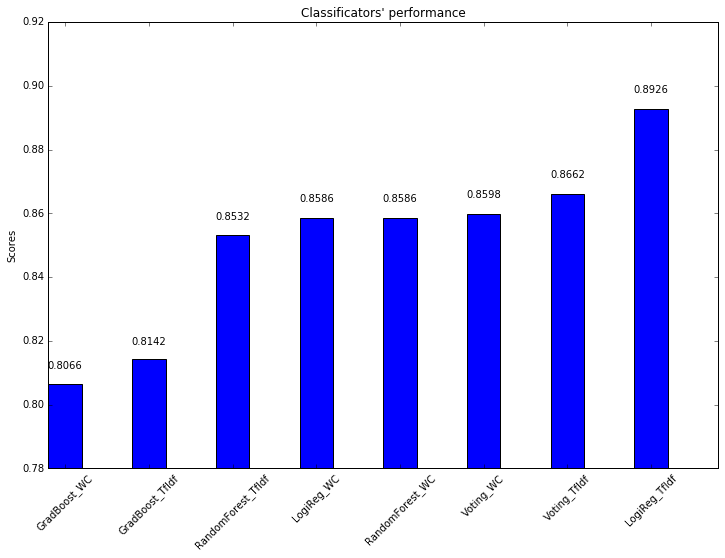

In [45]:
dic_results = {'RandomForest_WC': eval_RF_1_tts,
               'RandomForest_TfIdf': eval_RF_2_tts,
               'LogiReg_WC': eval_LR_1_tts,
               'LogiReg_TfIdf': eval_LR_2_tts,
               'GradBoost_WC': eval_GBC_1_tts,
               'GradBoost_TfIdf': eval_GBC_2_tts,
               'Voting_WC': eval_vot_1_tts,
               'Voting_TfIdf': eval_vot_2_tts,
              }

import operator
tup_results = sorted(dic_results.items(), key=operator.itemgetter(1))

N = len(dic_results)
ind = np.arange(N)  # the x locations for the groups
width = 0.40       # the width of the bars

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
rects = ax.bar(ind, list(zip(*tup_results))[1], width,)
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x()+rect.get_width()/2., 
            1.005*height, 
            '{0:.4f}'.format(height), 
            ha='center', 
            va='bottom',)

ax.set_ylabel('Scores')
ax.set_ylim(ymin=0.78,ymax = 0.92)
ax.set_title("Classificators' performance")
ax.set_xticks(ind + width/2.)
ax.set_xticklabels(list(zip(*tup_results))[0], rotation=45)

plt.show()

Creating a Submission  
--

All that remains is to run the best classifier on our test set and create a submission file. If you haven't already done so, download testData.tsv from the Data page. This file contains another 25,000 reviews and ids; our task is to predict the sentiment label.

Note that when we use the Bag of Words for the test set, we only call "transform", not "fit_transform" as we did for the training set. In machine learning, you shouldn't use the test set to fit your model, otherwise you run the risk of overfitting. For this reason, we keep the test set off-limits until we are ready to make predictions.

In [46]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
id        25000 non-null object
review    25000 non-null object
dtypes: object(2)
memory usage: 390.7+ KB


In [47]:
test.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [48]:
# Use the logistic regression to make sentiment label predictions
result = clf_LR_2.predict(test_data_features2)
result_prob = clf_LR_2.predict_proba(test_data_features2)
output = pd.DataFrame(data={"id":test["id"], "sentiment":result,})# "probs":result_prob[:,1]})
# Use pandas to write the comma-separated output file
output.to_csv(os.path.join(outputs,'LR_tfidf_model.csv'), index=False, quoting=3)

In [49]:
output.head()

,id,sentiment
0,"""12311_10""",1
1,"""8348_2""",1
2,"""5828_4""",1
3,"""7186_2""",1
4,"""12128_7""",1


Part 2: Distributed Word Vectors
--

https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-2-word-vectors  

Introducing Distributed Word Vectors: This part of the tutorial will focus on using distributed word vectors created by the Word2Vec algorithm.

Word2vec, published by Google in 2013, is a neural network implementation that learns distributed representations for words. Other deep or recurrent neural network architectures had been proposed for learning word representations prior to this, but the major problem with these was the long time required to train the models. Word2vec learns quickly relative to other models.

Word2Vec does not need labels in order to create meaningful representations. This is useful, since most data in the real world is unlabeled. If the network is given enough training data (tens of billions of words), it produces word vectors with intriguing characteristics. Words with similar meanings appear in clusters, and clusters are spaced such that some word relationships, such as analogies, can be reproduced using vector math. The famous example is that, with highly trained word vectors, "king - man + woman = queen."

Distributed word vectors are powerful and can be used for many applications, particularly word prediction and translation. Here, we will try to apply them to sentiment analysis.

Using word2vec in Python: In Python, we will use the excellent implementation of word2vec from the gensim package. If you don't already have gensim installed, you'll need to install it. There is an excellent tutorial that accompanies the Python Word2Vec implementation, here.

Although Word2Vec does not require graphics processing units (GPUs) like many deep learning algorithms, it is compute intensive. Both Google's version and the Python version rely on multi-threading (running multiple processes in parallel on your computer to save time). ln order to train your model in a reasonable amount of time, you will need to install cython (instructions here). Word2Vec will run without cython installed, but it will take days to run instead of minutes.

Preparing to Train a Model

First, we read in the data with pandas, as we did in Part 1. Unlike Part 1, we now use unlabeledTrain.tsv, which contains 50,000 additional reviews with no labels. When we built the Bag of Words model in Part 1, extra unlabeled training reviews were not useful. However, since Word2Vec can learn from unlabeled data, these extra 50,000 reviews can now be used.  

The functions we write to clean the data are also similar to Part 1, although now there are a couple of differences. First, to train Word2Vec it is better not to remove stop words because the algorithm relies on the broader context of the sentence in order to produce high-quality word vectors. For this reason, we will make stop word removal optional in the functions below. It also might be better not to remove numbers, but we leave that as an exercise for the reader.  

In [50]:
def getCleanReviews(reviews):
    clean_reviews = []
    for review in reviews["review"]:
        clean_reviews.append(KaggleWord2VecUtility.review_to_wordlist(review, remove_stopwords=False))
    return clean_reviews

In [51]:
# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Split the labeled and unlabeled training sets into clean sentences
sentences = []  # Initialize an empty list of sentences
print("Parsing sentences from training set")
for review in train["review"]:
    sentences += KaggleWord2VecUtility.review_to_sentences(review, tokenizer)
    
print("Parsing sentences from unlabeled set")
for review in unlabeled_train["review"]:
    sentences += KaggleWord2VecUtility.review_to_sentences(review, tokenizer)

Parsing sentences from training set


/usr/local/lib/python3.5/dist-packages/bs4/__init__.py:198: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  '"%s" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.' % markup)
/usr/local/lib/python3.5/dist-packages/bs4/__init__.py:207: UserWarning: "b'http://www.happierabroad.com"'" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.
  '"%s" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.' % markup)


Parsing sentences from unlabeled set


/usr/local/lib/python3.5/dist-packages/bs4/__init__.py:207: UserWarning: "b'http://www.archive.org/details/LovefromaStranger"'" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.
  '"%s" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.' % markup)
/usr/local/lib/python3.5/dist-packages/bs4/__init__.py:207: UserWarning: "b'http://www.loosechangeguide.com/LooseChangeGuide.html"'" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.
  '"%s" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.' % markup)
/usr/loca

In [52]:
# Import the built-in logging module and configure it so that Word2Vec creates nice output messages
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

https://radimrehurek.com/gensim/models/word2vec.html  

Training and Saving Your Model

With the list of nicely parsed sentences, we're ready to train the model. There are a number of parameter choices that affect the run time and the quality of the final model that is produced. For details on the algorithms below, see the word2vec API documentation as well as the Google documentation. 

Architecture: Architecture options are skip-gram (default) or continuous bag of words. We found that skip-gram was very slightly slower but produced better results.

Training algorithm: Hierarchical softmax (default) or negative sampling. For us, the default worked well.

Downsampling of frequent words: The Google documentation recommends values between .00001 and .001. For us, values closer 0.001 seemed to improve the accuracy of the final model.

Word vector dimensionality: More features result in longer runtimes, and often, but not always, result in better models. Reasonable values can be in the tens to hundreds; we used 300.

Context / window size: How many words of context should the training algorithm take into account? 10 seems to work well for hierarchical softmax (more is better, up to a point).

Worker threads: Number of parallel processes to run. This is computer-specific, but between 4 and 6 should work on most systems.

Minimum word count: This helps limit the size of the vocabulary to meaningful words. Any word that does not occur at least this many times across all documents is ignored. Reasonable values could be between 10 and 100. In this case, since each movie occurs 30 times, we set the minimum word count to 40, to avoid attaching too much importance to individual movie titles. This resulted in an overall vocabulary size of around 15,000 words. Higher values also help limit run time.

Choosing parameters is not easy, but once we have chosen our parameters, creating a Word2Vec model is straightforward:

In [53]:
num_features = 300    # Word vector dimensionality
min_word_count = 20   # Minimum word count
num_workers = -1       # Number of threads to run in parallel
context = 10          # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

In [54]:
# Initialize and train the model (this will take some time)
model = Word2Vec(sentences,
                 workers = num_workers,
                 size = num_features,
                 min_count = min_word_count, 
                 window = context,
                 sample = downsampling,
                 seed=1,)

In [55]:
# If you don't plan to train the model any further, calling init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

In [56]:
# It can be helpful to create a meaningful model name and save the model for later use. 
#You can load it later using Word2Vec.load()
model_name = "300features_20minwords_10context"
model.save(os.path.join(outputs,model_name))
model = Word2Vec.load(os.path.join(outputs,model_name))

Exploring the Model Results

Congratulations on making it successfully through everything so far! Let's take a look at the model we created out of our 75,000 training reviews.

The "doesnt_match" function will try to deduce which word in a set is most dissimilar from the others:

In [57]:
print(model.doesnt_match("man woman child kitchen".split()))
print(model.doesnt_match("france england germany berlin".split()))
print(model.doesnt_match("paris berlin london austria".split()))
print(model.most_similar("man"))
print(model.most_similar("queen"))
print(model.most_similar("awful"))

woman
germany
paris
[('north', 0.23120811581611633), ('literally', 0.22275817394256592), ('exchange', 0.21795308589935303), ('hurl', 0.2158883512020111), ('heh', 0.21347549557685852), ('extremists', 0.21252413094043732), ('faints', 0.20652957260608673), ('adama', 0.2036851942539215), ('hugely', 0.1960485875606537), ('disrupted', 0.19528979063034058)]
[('tolstoy', 0.251092791557312), ('fleshing', 0.22077207267284393), ('histories', 0.21041344106197357), ('cavern', 0.20596039295196533), ('idiocy', 0.2045907825231552), ('boyish', 0.19907249510288239), ('paxinou', 0.19874174892902374), ('bryant', 0.19759152829647064), ('doings', 0.19686591625213623), ('oh', 0.19670671224594116)]
[('wikipedia', 0.23838505148887634), ('faith', 0.21923106908798218), ('motions', 0.21709153056144714), ('successors', 0.19928669929504395), ('entitled', 0.19770026206970215), ('harmful', 0.19639436900615692), ('weaknesses', 0.19632156193256378), ('satellite', 0.19572806358337402), ('survivor', 0.19540515542030334),

So it seems we have a reasonably good model for semantic meaning - at least as good as Bag of Words. But how can we use these fancy distributed word vectors for supervised learning? The next section takes a stab at that.

Part 3: More Fun With Word Vectors
--

https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-3-more-fun-with-word-vectors  

Numeric Representations of Words

Now that we have a trained model with some semantic understanding of words, how should we use it? If you look beneath the hood, the Word2Vec model trained in Part 2 consists of a feature vector for each word in the vocabulary, stored in a numpy array called "syn0":

In [76]:
model = Word2Vec.load(os.path.join(outputs,model_name))

In [77]:
model.syn0.shape

(24156, 300)

The number of rows in syn0 is the number of words in the model's vocabulary, and the number of columns corresponds to the size of the feature vector, which we set in Part 2.  Setting the minimum word count to 40 gave us a total vocabulary of 16,492 words with 300 features apiece. Individual word vectors can be accessed in the following way:

In [78]:
model["flower"][0:10]

array([-0.02701798,  0.04598043,  0.01979387,  0.04681111, -0.00648649,
       -0.0659649 ,  0.00305438, -0.06200789, -0.05690301,  0.06336904], dtype=float32)

In [79]:
model.index2word[0:10]

['the', 'and', 'a', 'of', 'to', 'is', 'it', 'in', 'i', 'this']

From Words To Paragraphs, 
--
Attempt 1:  Vector Averaging  
--

One challenge with the IMDB dataset is the variable-length reviews. We need to find a way to take individual word vectors and transform them into a feature set that is the same length for every review.

Since each word is a vector in 300-dimensional space, we can use vector operations to combine the words in each review. One method we tried was to simply average the word vectors in a given review (for this purpose, we removed stop words, which would just add noise).

The following code averages the feature vectors, building on our code from Part 2. 

In [62]:
def makeFeatureVec(words, model, num_features):
    # Function to average all of the word vectors in a given paragraph
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    # Index2word is a list that contains the names of the words in the model's vocabulary. 
    #Convert it to a set, for speed
    index2word_set = set(model.index2word)
    # Loop over each word in the review and, if it is in the model's
    # vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set:
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return featureVec

In [63]:
def getAvgFeatureVecs(reviews, model, num_features):
    # Given a set of reviews (each one a list of words), calculate
    # the average feature vector for each one and return a 2D numpy array
    # Initialize a counter
    counter = 0.
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    # Loop through the reviews
    for review in reviews:
        # Print a status message every 2000th review
        if counter%2000. == 0.:
            print("Review {} of {}".format(counter, len(reviews)))
        #Call the function (defined above) that makes average feature vectors
        reviewFeatureVecs[counter] = makeFeatureVec(review, model, num_features)
        counter = counter + 1.
    return reviewFeatureVecs

Let's use the pickles from Part 1  

In [64]:
with open(os.path.join(outputs, 'clean_reviews.pkl'),'rb') as f:
    clean_train_reviews, 
    clean_test_reviews = pickle.load(f)

with open(os.path.join(outputs, 'clean_reviews_sw.pkl'),'rb') as f:
    clean_train_reviews_sw, 
    clean_test_reviews_sw = pickle.load(f)

Now, we can call these functions to create average vectors for each paragraph. The following operations will take a few minutes:  

In [65]:
# Calculate average feature vectors for training and testing sets, using the functions 
# we defined above. Notice that we now use stop word removal.
trainDataVecs = getAvgFeatureVecs(clean_train_reviews, model, num_features)

Review 0.0 of 25000
Review 2000.0 of 25000
Review 4000.0 of 25000
Review 6000.0 of 25000
Review 8000.0 of 25000
Review 10000.0 of 25000
Review 12000.0 of 25000
Review 14000.0 of 25000
Review 16000.0 of 25000
Review 18000.0 of 25000
Review 20000.0 of 25000
Review 22000.0 of 25000
Review 24000.0 of 25000


Next, use the average paragraph vectors with the classifiers from Part 1.  
Note that, as in Part 1, we can only use the labeled training reviews to train the model. 

In [66]:
X_traincvWV, X_testcvWV, y_traincvWV, y_testcvWV = train_test_split(trainDataVecs,
                                                                    train["sentiment"],
                                                                    test_size=0.2,
                                                                    random_state=0)

In [67]:
# Initialize a Random Forest classifier with 300 trees
clf_RF_WV = RandomForestClassifier(n_estimators=300, 
                                   criterion='gini', 
                                   max_depth=None, 
                                   min_samples_split=2, 
                                   min_samples_leaf=1, 
                                   min_weight_fraction_leaf=0.0, 
                                   max_features='auto', 
                                   max_leaf_nodes=None, 
                                   bootstrap=False, 
                                   oob_score=False, 
                                   n_jobs=-1, 
                                   random_state=None, 
                                   verbose=0, 
                                   warm_start=False, 
                                   class_weight=None).fit(X_traincvWV, y_traincvWV)

eval_RF_WV_tts = clf_RF_WV.score(X_testcvWV, y_testcvWV)
print(eval_RF_WV_tts)

0.617


In [68]:
clf_LR_WV = LR(penalty='l2',
               dual=False,
               tol=0.0001,
               C=1.0,
               fit_intercept=True,
               intercept_scaling=1,
               class_weight=None,
               random_state=None,
               solver='liblinear',
               max_iter=100,
               multi_class='ovr',
               verbose=0).fit(X_traincvWV, y_traincvWV)

eval_LR_WV_tts = clf_LR_WV.score(X_testcvWV, y_testcvWV)
print(eval_LR_WV_tts)

0.593


Creating a Submission  
--

In [69]:
testDataVecs = getAvgFeatureVecs(clean_test_reviews[0], model, num_features)

Review 0.0 of 25000
Review 2000.0 of 25000
Review 4000.0 of 25000
Review 6000.0 of 25000
Review 8000.0 of 25000
Review 10000.0 of 25000
Review 12000.0 of 25000
Review 14000.0 of 25000
Review 16000.0 of 25000
Review 18000.0 of 25000
Review 20000.0 of 25000
Review 22000.0 of 25000
Review 24000.0 of 25000


In [70]:
print(np.isnan(testDataVecs).any()) #testando se não há valores que inviabilizam o treinamento
print(np.isfinite(testDataVecs).all())

False
True


In [71]:
from sklearn.preprocessing import Imputer
testDataVecs = Imputer().fit_transform(testDataVecs)

print(np.isnan(testDataVecs).any()) #testando se não há valores que inviabilizam o treinamento
print(np.isfinite(testDataVecs).all())

False
True


In [72]:
# Use the random forest to make sentiment label predictions
result = clf_RF_WV.predict(testDataVecs)
result_prob = clf_RF_WV.predict_proba(testDataVecs)
output = pd.DataFrame(data={"id":test["id"], "sentiment":result,})# "probs":result_prob[:,1]})
# Use pandas to write the comma-separated output file
output.to_csv(os.path.join(outputs,'Word2Vec_AverageVectors.csv'), index=False, quoting=3)

In [73]:
output.head()

,id,sentiment
0,"""12311_10""",1
1,"""8348_2""",1
2,"""5828_4""",0
3,"""7186_2""",0
4,"""12128_7""",0


We found that this produced results much better than chance, but underperformed Bag of Words by a few percentage points.

Since the element-wise average of the vectors didn't produce spectacular results, perhaps we could do it in a more intelligent way? A standard way of weighting word vectors is to apply "tf-idf" weights, which measure how important a given word is within a given set of documents. One way to extract tf-idf weights in Python is by using scikit-learn's TfidfVectorizer, which has an interface similar to the CountVectorizer that we used in Part 1. However, when we tried weighting our word vectors in this way, we found no substantial improvement in performance.

From Words to Paragraphs, Attempt 2: Clustering 
--

Word2Vec creates clusters of semantically related words, so another possible approach is to exploit the similarity of words within a cluster. Grouping vectors in this way is known as "vector quantization." To accomplish this, we first need to find the centers of the word clusters, which we can do by using a clustering algorithm such as K-Means.

In K-Means, the one parameter we need to set is "K," or the number of clusters. How should we decide how many clusters to create? Trial and error suggested that small clusters, with an average of only 5 words or so per cluster, gave better results than large clusters with many words. Clustering code is given below. We use scikit-learn to perform our K-Means.

K-Means clustering with large K can be very slow; the following code took more than 40 minutes on my computer. Below, we set a timer around the K-Means function to see how long it takes.

In [80]:
start = time.time()

# Set "k" (num_clusters) to be 1/5th of the vocabulary size, or an average of 5 words per cluster
word_vectors = model.syn0
num_clusters = int(word_vectors.shape[0] / 5)

# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans(n_clusters = num_clusters)
idx = kmeans_clustering.fit_predict(word_vectors)

end = time.time()
elapsed = end - start
print("Time taken for K Means clustering: ", elapsed, "seconds.")

Time taken for K Means clustering:  3360.78120803833 seconds.


The cluster assignment for each word is now stored in idx, and the vocabulary from our original Word2Vec model is still stored in model.index2word. For convenience, we zip these into one dictionary as follows:  

In [81]:
# Create a Word / Index dictionary, mapping each vocabulary word to a cluster number
word_centroid_map = dict(zip(model.index2word, idx))

This is a little abstract, so let's take a closer look at what our clusters contain. Your clusters may differ, as Word2Vec relies on a random number seed. Here is a loop that prints out the words for clusters 0 through 9:

Run k-means on the word vectors and print a few clusters  

In [101]:
# Print the first ten clusters
for cluster in range(0,10):
    # Print the cluster number
    print("\nCluster {}".format(cluster))
    # Find all of the words for that cluster number, and print them out
    words = []
    for i in range(0,len(word_centroid_map.values())):
        #print(len(word_centroid_map.values()))
        #print(cluster)
        #print(word_centroid_map.keys())
        if(list(word_centroid_map.values())[i] == cluster):
            words.append(list(word_centroid_map.keys())[i])
    print(words)


Cluster 0
['ideology', 'mainly', 'evolved', 'flint']

Cluster 1
['bang', 'purportedly', 'lit', 'conservatives']

Cluster 2
['forcefully', 'involves', 'meticulously', 'rawal', 'panther']

Cluster 3
['captivates', 'sales', 'dismiss', 'characterization']

Cluster 4
['unseen', 'shifting', 'theatrically']

Cluster 5
['trips', 'tagore', 'unbeknownst']

Cluster 6
['invisibility', 'tavern', 'dupe', 'courtship']

Cluster 7
['sleaze']

Cluster 8
['streets', 'spoof', 'les', 'squarely', 'splatter']

Cluster 9
['combo', 'flashdance', 'pushed']


We can see that the clusters are of varying quality. Some make sense, some cointain mostly names, and some contain related adjectives. On the other hand, some are a little mystifying. Perhaps our algorithm works best on adjectives.

At any rate, now we have a cluster (or "centroid") assignment for each word, and we can define a function to convert reviews into bags-of-centroids. This works just like Bag of Words but uses semantically related clusters instead of individual words:

In [102]:
def create_bag_of_centroids(wordlist, word_centroid_map):
    # The number of clusters is equal to the highest cluster index in the word / centroid map
    num_centroids = max(word_centroid_map.values()) + 1
    # Pre-allocate the bag of centroids vector (for speed)
    bag_of_centroids = np.zeros(num_centroids, dtype="float32")
    # Loop over the words in the review. If the word is in the vocabulary,
    # find which cluster it belongs to, and increment that cluster count by one
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1
    return bag_of_centroids

The function above will give us a numpy array for each review, each with a number of features equal to the number of clusters. Finally, we create bags of centroids for our training and test set, then train a random forest and extract results:

In [103]:
# ****** Create bags of centroids

# Pre-allocate an array for the training set bags of centroids (for speed)
train_centroids = np.zeros((train["review"].size, num_clusters), dtype="float32")

# Transform the training set reviews into bags of centroids
counter = 0
for review in clean_train_reviews:
    train_centroids[counter] = create_bag_of_centroids(review, word_centroid_map)
    counter += 1

In [104]:
X_traincvCT, X_testcvCT, y_traincvCT, y_testcvCT = train_test_split(train_centroids,
                                                                    train["sentiment"],
                                                                    test_size=0.2,
                                                                    random_state=0)

In [105]:
# Initialize a Random Forest classifier with 100 trees
clf_RF_CT = RandomForestClassifier(n_estimators=100, 
                                   criterion='gini', 
                                   max_depth=None, 
                                   min_samples_split=2, 
                                   min_samples_leaf=1, 
                                   min_weight_fraction_leaf=0.0, 
                                   max_features='auto', 
                                   max_leaf_nodes=None, 
                                   bootstrap=True, 
                                   oob_score=False, 
                                   n_jobs=1, 
                                   random_state=None, 
                                   verbose=0, 
                                   warm_start=False, 
                                   class_weight=None).fit(X_traincvCT, y_traincvCT)

In [106]:
eval_RF_CT_tts = clf_RF_CT.score(X_testcvCT, y_testcvCT)
print(eval_RF_CT_tts)

0.598


In [107]:
# Repeat for test reviews
test_centroids = np.zeros((test["review"].size, num_clusters), dtype="float32")

counter = 0
for review in clean_test_reviews:
    test_centroids[counter] = create_bag_of_centroids(review, word_centroid_map)
    counter += 1

In [109]:
result = clf_RF_CT.predict(test_centroids)

# Write the test results
output = pd.DataFrame(data={"id":test["id"], "sentiment":result})
output.to_csv(os.path.join(outputs,"BagOfCentroids.csv"), index=False, quoting=3)
print("Wrote BagOfCentroids.csv")

Wrote BagOfCentroids.csv


We found that the code above gives about the same (or slightly worse) results compared to the Bag of Words in Part 1.

Part 4: Comparing deep and non-deep learning methods
--

You may ask: Why is Bag of Words better?

The biggest reason is, in our tutorial, averaging the vectors and using the centroids lose the order of words, making it very similar to the concept of Bag of Words. The fact that the performance is similar (within range of standard error) makes all three methods practically equivalent.  

A few things to try:

First, training Word2Vec on a lot more text should greatly improve performance. Google's results are based on word vectors that were learned out of more than a billion-word corpus; our labeled and unlabeled training sets together are only a measly 18 million words or so. Conveniently, Word2Vec provides functions to load any pre-trained model that is output by Google's original C tool, so it's also possible to train a model in C and then import it into Python.

Second, in published literature, distributed word vector techniques have been shown to outperform Bag of Words models. In this paper, an algorithm called Paragraph Vector is used on the IMDB dataset to produce some of the most state-of-the-art results to date. In part, it does better than the approaches we try here because vector averaging and clustering lose the word order, whereas Paragraph Vectors preserves word order information.

What is Deep Learning?

The term "deep learning" was coined in 2006, and refers to machine learning algorithms that have multiple non-linear layers and can learn feature hierarchies [1].

Most modern machine learning relies on feature engineering or some level of domain knowledge to obtain good results. In deep learning systems, this is not the case -- instead, algorithms can automatically learn feature hierarchies, which represent objects in increasing levels of abstraction. Although the basic ingredients of many deep learning algorithms have been around for many years, they are currently increasing in popularity for many reasons, including advances in compute power, the falling cost of computing hardware, and advances in machine learning research.

Deep learning algorithms can be categorized by their architecture (feed-forward, feed-back, or bi-directional) and training protocols (purely supervised, hybrid, or unsupervised) [2]. 

Some good background materials include:

[1] "Deep Learning for Signal and Information Processing", by Li Deng and Dong Yu (out of Microsoft)

[2] "Deep Learning Tutorial" (2013 Presentation by Yann LeCun and Marc'Aurelio Ranzato)

Where Does Word2Vec Fit In?

Word2Vec works in a way that is similar to deep approaches such as recurrent neural nets or deep neural nets, but it implements certain algorithms, such as hierarchical softmax, that make it computationally more efficient.  

See Part 2 of this tutorial for more on Word2Vec, as well as this paper: Efficient Estimation of Word Representations in Vector Space

In this tutorial, we use a hybrid approach to training -- consisting of an unsupervised piece (Word2Vec) followed by supervised learning (the Random Forest). 

Libraries and Packages 

The lists below should in no way be considered exhaustive.

In Python:

Theano offers very low-level, nuts and bolts functionality for building deep learning systems. You can also find some good tutorials on their site.  
Caffe is a deep learning framework out of the Berkeley Vision and Learning Center.  
Pylearn2 wraps Theano and seems slightly more user friendly.  
OverFeat was used to win the Kaggle Cats and Dogs competition.  


More Tutorials  
The O'Reilly Blog has a series of deep learning articles and tutorials:  

http://radar.oreilly.com/2014/07/what-is-deep-learning-and-why-should-you-care.html  
http://radar.oreilly.com/2014/07/how-to-build-and-run-your-first-deep-learning-network.html  
Webcast: How to Get Started with Deep Learning in Computer Vision  
There are several tutorials using Theano as well.  

If you want to dive into the weeds of creating a neural network from scratch, check out Geoffrey Hinton's Coursera course.

For NLP, check out this recent lecture at Stanford: http://techtalks.tv/talks/deep-learning-for-nlp-without-magic-part-1/58414/  

This free, online book also introduces neural nets for deep learning: http://neuralnetworksanddeeplearning.com/  